In [19]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel, BertTokenizer, BertModel
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Is CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

PyTorch version: 2.5.1+cu121
CUDA version: 12.1
Is CUDA available: True
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [21]:
# Paths
base_path = 'D:/Document/BUET/Data Mining/dataset/BHM'
files_path = os.path.join(base_path, 'Files')
memes_path = os.path.join(base_path, 'Memes')

# Load datasets
train_data = pd.read_excel(os.path.join(files_path, 'train_task2.xlsx'))
valid_data = pd.read_excel(os.path.join(files_path, 'valid_task2.xlsx'))
test_data = pd.read_excel(os.path.join(files_path, 'test_task2.xlsx'))


In [22]:
# Data Preparation
class MemeDataset(Dataset):
    def __init__(self, dataframe, image_folder, transforms=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.image_folder, row['image_name'])
        image = Image.open(image_path).convert("RGB")
        if self.transforms:
            image = self.transforms(image)
        text = row['Captions']
        label = row['Labels']
        return image, text, label

In [38]:
# Map labels to integers

label_mapping_task2 = {"TC": 0, "TI": 1, "TO": 2, "TS": 3}
train_data['Labels'] = train_data['Labels'].map(label_mapping_task2)
valid_data['Labels'] = valid_data['Labels'].map(label_mapping_task2)
test_data['Labels'] = test_data['Labels'].map(label_mapping_task2)

In [39]:
# Image transformations
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [40]:
# DataLoader function
def create_dataloader(dataframe, image_folder, transforms, batch_size):
    dataset = MemeDataset(dataframe, image_folder, transforms)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_size = 16
train_loader = create_dataloader(train_data, memes_path, image_transforms, batch_size)
valid_loader = create_dataloader(valid_data, memes_path, image_transforms, batch_size)
test_loader = create_dataloader(test_data, memes_path, image_transforms, batch_size)


In [41]:
!pip install transformers torchvision torch scikit-learn pandas matplotlib


In [42]:
# Load Models
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").eval()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_model = BertModel.from_pretrained("bert-base-multilingual-cased").eval()


In [43]:
# Feature Extraction Functions
def extract_image_features(images):
    with torch.no_grad():
        return clip_model.get_image_features(images.to(torch.float16 if torch.cuda.is_available() else torch.float32))

def extract_text_features(texts):
    inputs = bert_tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.pooler_output  # Use the [CLS] token representation

In [44]:
# Extract Features
def extract_features(dataloader, split):
    image_features, text_features, labels = [], [], []
    for images, texts, lbls in dataloader:
        img_feats = extract_image_features(images)
        txt_feats = extract_text_features(texts)
        image_features.append(img_feats.cpu().numpy())
        text_features.append(txt_feats.cpu().numpy())
        labels.extend(lbls)
    np.save(f"{split}_image_features.npy", np.vstack(image_features))
    np.save(f"{split}_text_features.npy", np.vstack(text_features))
    np.save(f"{split}_labels.npy", np.array(labels))

extract_features(train_loader, "train")
extract_features(valid_loader, "valid")
extract_features(test_loader, "test")

In [45]:
# Load Features
train_image_features = np.load("train_image_features.npy")
train_text_features = np.load("train_text_features.npy")
train_labels = np.load("train_labels.npy")
valid_image_features = np.load("valid_image_features.npy")
valid_text_features = np.load("valid_text_features.npy")
valid_labels = np.load("valid_labels.npy")
test_image_features = np.load("test_image_features.npy")
test_text_features = np.load("test_text_features.npy")
test_labels = np.load("test_labels.npy")

In [46]:
# Concatenate Features
train_features = np.hstack((train_image_features, train_text_features))
valid_features = np.hstack((valid_image_features, valid_text_features))
test_features = np.hstack((test_image_features, test_text_features))


In [47]:
# Neural Network for Classification
class MemeClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MemeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

input_size = train_features.shape[1]
hidden_size = 256
num_classes = len(np.unique(train_labels))
model = MemeClassifier(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

In [55]:
# Training the Model
def train_model(model, train_features, train_labels, valid_features, valid_labels, epochs=10):
    for epoch in range(epochs):
        model.train()
        inputs = torch.tensor(train_features, dtype=torch.float32)
        labels = torch.tensor(train_labels, dtype=torch.long)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_inputs = torch.tensor(valid_features, dtype=torch.float32)
            val_labels = torch.tensor(valid_labels, dtype=torch.long)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            val_predictions = torch.argmax(val_outputs, dim=1).numpy()
            val_accuracy = accuracy_score(valid_labels, val_predictions)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

train_model(model, train_features, train_labels, valid_features, valid_labels, epochs=200)

Epoch 1/200, Loss: 0.0283, Val Loss: 0.9975, Val Accuracy: 0.7925
Epoch 2/200, Loss: 0.0285, Val Loss: 0.9973, Val Accuracy: 0.7925
Epoch 3/200, Loss: 0.0273, Val Loss: 0.9943, Val Accuracy: 0.7842
Epoch 4/200, Loss: 0.0260, Val Loss: 0.9938, Val Accuracy: 0.7842
Epoch 5/200, Loss: 0.0290, Val Loss: 0.9960, Val Accuracy: 0.7842
Epoch 6/200, Loss: 0.0306, Val Loss: 0.9982, Val Accuracy: 0.7842
Epoch 7/200, Loss: 0.0263, Val Loss: 0.9991, Val Accuracy: 0.7842
Epoch 8/200, Loss: 0.0283, Val Loss: 0.9967, Val Accuracy: 0.7842
Epoch 9/200, Loss: 0.0280, Val Loss: 0.9961, Val Accuracy: 0.7884
Epoch 10/200, Loss: 0.0276, Val Loss: 0.9963, Val Accuracy: 0.7884
Epoch 11/200, Loss: 0.0273, Val Loss: 0.9980, Val Accuracy: 0.7884
Epoch 12/200, Loss: 0.0285, Val Loss: 0.9978, Val Accuracy: 0.7884
Epoch 13/200, Loss: 0.0258, Val Loss: 0.9998, Val Accuracy: 0.7884
Epoch 14/200, Loss: 0.0260, Val Loss: 1.0004, Val Accuracy: 0.7925
Epoch 15/200, Loss: 0.0263, Val Loss: 0.9974, Val Accuracy: 0.7884
Epoc

In [56]:
# Evaluation
model.eval()
with torch.no_grad():
    test_inputs = torch.tensor(test_features, dtype=torch.float32)
    test_outputs = model(test_inputs)
    test_predictions = torch.argmax(test_outputs, dim=1).numpy()

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=['TC', 'TI', 'TO', 'TS']))

Classification Report:
              precision    recall  f1-score   support

          TC       0.32      0.22      0.26        37
          TI       0.82      0.88      0.85       193
          TO       0.45      0.48      0.46        27
          TS       0.25      0.11      0.15         9

    accuracy                           0.72       266
   macro avg       0.46      0.42      0.43       266
weighted avg       0.69      0.72      0.70       266



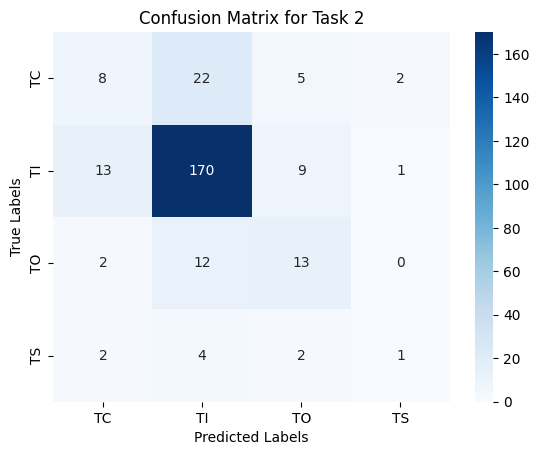

In [57]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['TC', 'TI', 'TO', 'TS'], yticklabels=['TC', 'TI', 'TO', 'TS'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Task 2")
plt.show()